In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Calendar

#### Year

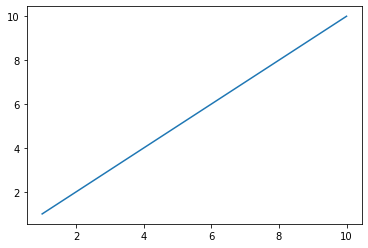

In [2]:
x = np.arange(1,11)
def calc_year(x):
    return 1*x
plt.plot(x,calc_year(x))

#### Month

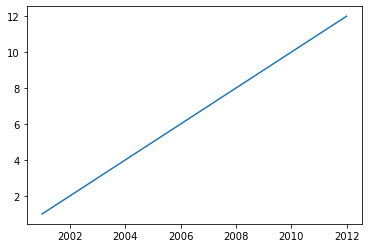

In [3]:
x = 2000 + np.arange(1,13)
def calc_month(x):
    return 1*(x-2000)
plt.plot(x,calc_month(x))

#### Day

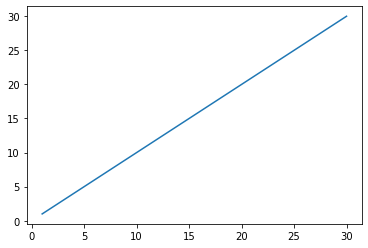

In [4]:
x = np.arange(1,31)
def calc_day(x):
    return 1*x
plt.plot(x,calc_day(x))

#### Hour

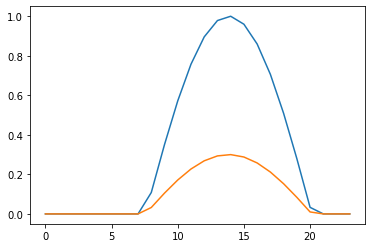

In [5]:
x = np.arange(0,24)
def calc_hour(x, y):
    weekend_effect = 0.3 if y in [5,6] else 1
    return np.maximum(0, -1*np.sin((x+5)/4)*weekend_effect)
plt.plot(x,calc_hour(x,1))
plt.plot(x,calc_hour(x,6))

In [6]:
def calc_value(dt):
    year_term = calc_year(dt.year)
    month_term = calc_month(dt.month)
    day_term = calc_day(dt.day)
    hour_term = calc_hour(dt.hour, dt.dayofweek)
    value = 0.1*year_term + 0.1*month_term  + 0.1*day_term + 1*hour_term
    return value

### Build TimeSeries

In [7]:
df = pd.DataFrame()
df['date'] = pd.date_range("2012-01-01", periods=24*365.25*10, freq="H")

In [8]:
df['value'] = df['date'].apply(calc_value)

In [9]:
df['month_transition'] = (df.date.dt.is_month_end) | (df.date.dt.is_month_start)
df['year_transition'] = (df.date.dt.is_year_end) | (df.date.dt.is_year_start)
df['weekend'] = df.date.dt.dayofweek.isin([5,6])
df['holiday'] = False
for year_ in df.date.dt.year.unique():
    holidays = np.random.choice(range(1,366), 10)
    df.loc[(df.date.dt.year==year_) & (df.date.dt.dayofyear.isin(holidays)), 'holiday']=True

In [10]:
df.loc[df.holiday, 'value']=1

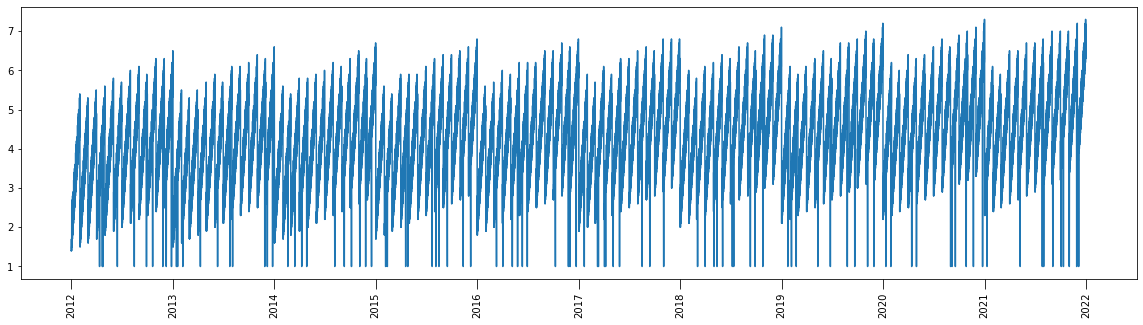

In [11]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df.date, df['value'], '-')
ax.tick_params(axis='x', size=10, labelrotation = 90)

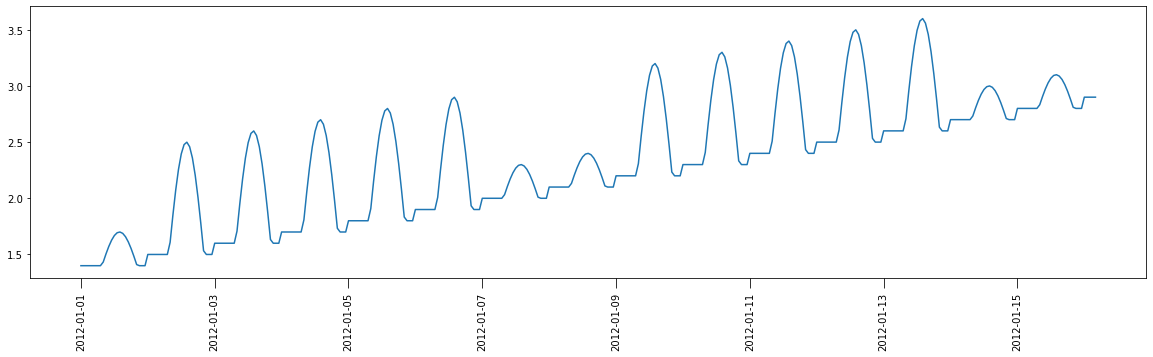

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['date'][0:365], df['value'][0:365], '-')
ax.tick_params(axis='x', size=10, labelrotation = 90)

#### Day, Week Transition

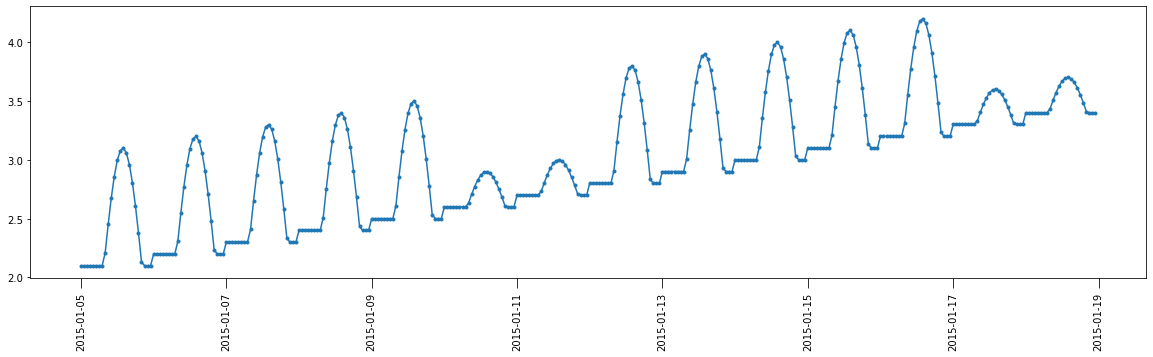

In [13]:
# day transistion
idx = (df.date.dt.year==2015) & (df.date.dt.month==1) & (df.date.dt.isocalendar().week.isin([2,3]))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df.loc[idx,'date'], df.loc[idx,'value'], '.-')
ax.tick_params(axis='x', size=10, labelrotation = 90)

### Holidays

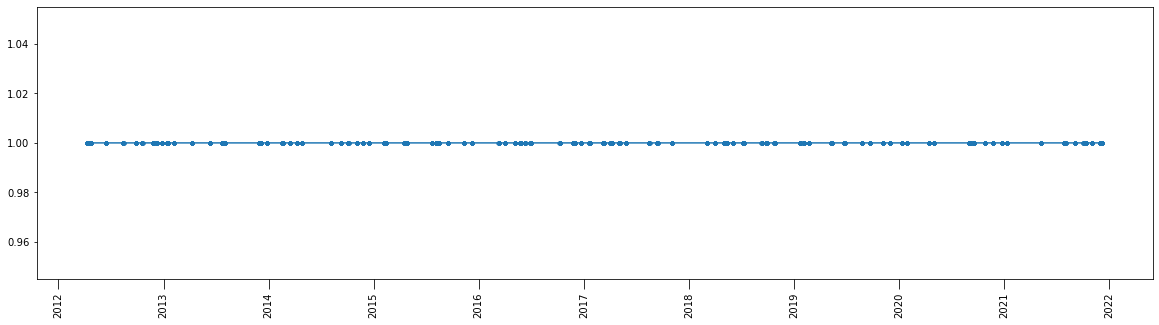

In [14]:
idx = (df.holiday)
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df.loc[idx,'date'], df.loc[idx,'value'], '.-')
ax.tick_params(axis='x', size=10, labelrotation = 90)

#### Month Transistion

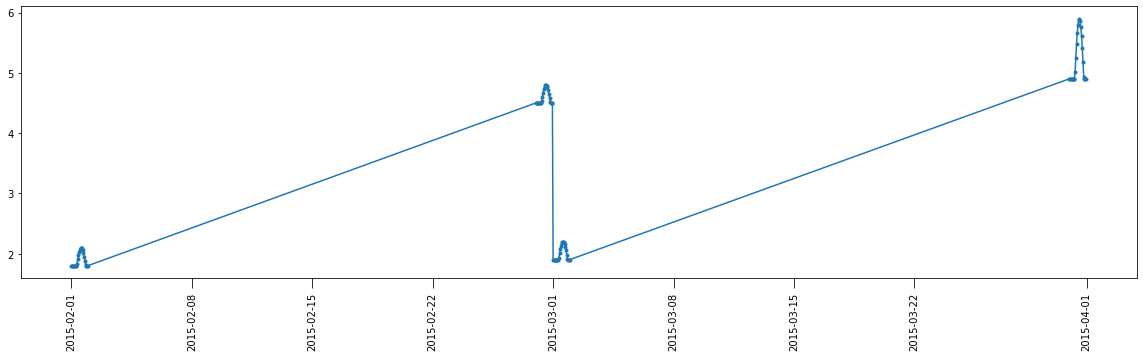

In [15]:
idx = (df.date.dt.year==2015) & (df.month_transition) & (df.date.dt.month.isin([2,3]))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df.loc[idx,'date'], df.loc[idx,'value'], '.-')
ax.tick_params(axis='x', size=10, labelrotation = 90)

#### Year Transistion

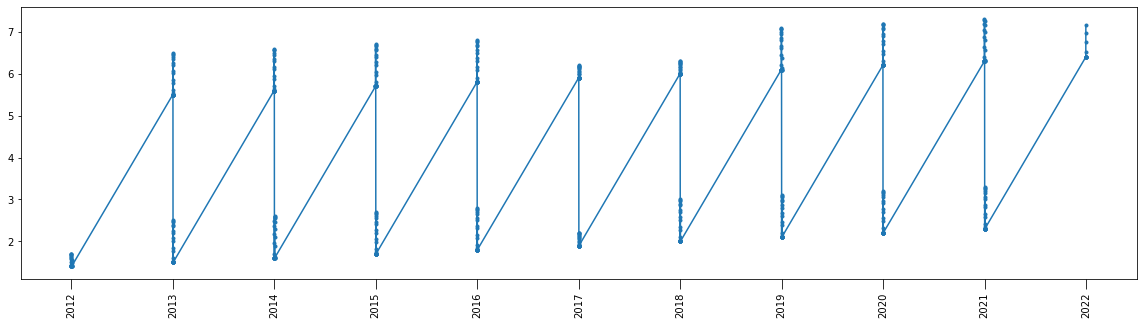

In [16]:
idx = (df.year_transition)
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df.loc[idx,'date'], df.loc[idx,'value'], '.-')
ax.tick_params(axis='x', size=10, labelrotation = 90)

### Analysis of Variance

In [17]:
glob_mean = df.value.mean()
for time_unit in ['year','month','day','hour']:
    date_format_dict = {'year':"%Y", 'month':'%Y-%m', 'day':'%Y-%m-%d', 'hour':"%Y-%m-%d %H:00"}
    date_format = date_format_dict[time_unit]
    df['time'] = df['date'].dt.strftime(date_format)
    summ_df = df.groupby('time').agg(value=('value','mean')).reset_index(drop=False)
    variance1 = np.mean((summ_df.value-glob_mean)**2)
#    variance2 = summ_df.value.var()
    print(time_unit, variance1)

year 0.0790491859114664
month 0.19932593848016988
day 1.2243396026396094
hour 1.3321882293891174


### Summarize by Time Unit

In [18]:
def summarize_dataset(df, time_unit='day', value_col='value', num_X=None):
    num_X_dict = {'year':2, 'month':12, 'day':60, 'hour':48}
    date_format_dict = {'year':"%Y", 'month':'%Y-%m', 'day':'%Y-%m-%d', 'hour':"%Y-%m-%d %H:00"}
    
    if time_unit not in num_X_dict.keys():
        return
    
    if num_X is None:
        num_X = num_X_dict[time_unit]    
    date_format = date_format_dict[time_unit]
    
    df['time'] = df['date'].dt.strftime(date_format)
    summ_df = df.groupby('time').agg(value=(value_col,'mean')).reset_index(drop=False)
    summ_df.sort_values('time', inplace=True)
    for idx in range(num_X):
        summ_df[value_col + '_' + str(idx)] = summ_df.rolling(num_X).value.apply(lambda x: np.array(x)[idx])
    return summ_df

##### value

In [19]:
time_unit = 'hour'
summ_df = summarize_dataset(df, time_unit)
summ_df.tail()

,time,value,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,...,value_38,value_39,value_40,value_41,value_42,value_43,value_44,value_45,value_46,value_47
87655,2021-12-31 07:00,6.400000,6.308195,6.550783,6.771561,6.956802,7.094989,7.177530,7.199293,7.158924,...,6.3,6.3,6.4,6.4,6.4,6.4,6.400000,6.400000,6.400000,6.400000
87656,2021-12-31 08:00,6.508195,6.550783,6.771561,6.956802,7.094989,7.177530,7.199293,7.158924,7.058934,...,6.3,6.4,6.4,6.4,6.4,6.4,6.400000,6.400000,6.400000,6.508195
87657,2021-12-31 09:00,6.750783,6.771561,6.956802,7.094989,7.177530,7.199293,7.158924,7.058934,6.905540,...,6.4,6.4,6.4,6.4,6.4,6.4,6.400000,6.400000,6.508195,6.750783
87658,2021-12-31 10:00,6.971561,6.956802,7.094989,7.177530,7.199293,7.158924,7.058934,6.905540,6.708279,...,6.4,6.4,6.4,6.4,6.4,6.4,6.400000,6.508195,6.750783,6.971561
87659,2021-12-31 11:00,7.156802,7.094989,7.177530,7.199293,7.158924,7.058934,6.905540,6.708279,6.479415,...,6.4,6.4,6.4,6.4,6.4,6.4,6.508195,6.750783,6.971561,7.156802


In [20]:
summ_df.dropna(inplace=True)
summ_df.reset_index(drop=True, inplace=True)
summ_df.shape

(87613, 50)

In [21]:
summ_df.to_csv(time_unit + '_summary.csv', index=False)

##### holiday

In [22]:
summ_df = summarize_dataset(df, time_unit, 'holiday')
summ_df.tail()

,time,value,holiday_0,holiday_1,holiday_2,holiday_3,holiday_4,holiday_5,holiday_6,holiday_7,...,holiday_38,holiday_39,holiday_40,holiday_41,holiday_42,holiday_43,holiday_44,holiday_45,holiday_46,holiday_47
87655,2021-12-31 07:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87656,2021-12-31 08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87657,2021-12-31 09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87658,2021-12-31 10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87659,2021-12-31 11:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
summ_df.dropna(inplace=True)
summ_df.reset_index(drop=True, inplace=True)
summ_df.shape

(87613, 50)

In [24]:
summ_df.to_csv(time_unit + '_holiday_summary.csv', index=False)